In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from aging.plotting import figure, format_plots, PlotConfig

In [2]:
format_plots()
c = PlotConfig()

In [3]:
def minmax(df):
    df = df - df.min()
    return df / df.max()

In [4]:
syllable_classes = pd.read_csv('./v11_syllable_labels_v2.csv')

In [5]:
id_map = syllable_classes.set_index('Original ID')['Class']

In [6]:
colors = ['#c7eae5','#008C8D']
male_cmap = sns.blend_palette(colors, as_cmap=True)
colors = ['#fee6ce','#d94801']
female_cmap = sns.blend_palette(colors, as_cmap=True)

In [7]:
cmapmap = {
    'ont_males': male_cmap,
    'ont_females': female_cmap,
    'long_v2_male': male_cmap,
    'long_v2_female': female_cmap,
}

In [8]:
keep_syllables = np.loadtxt('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/to_keep_syllables_raw.txt', dtype=int)

df = pd.read_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/longtogeny_v2_males_raw_usage_matrix_v00.parquet').astype(float)
df = df[keep_syllables].groupby(['age','uuid','mouse']).mean()

# take only first sample from each week
ages= df.index.get_level_values('age')
weeks = (ages * 7) // 7
df['binned_age'] = weeks

sample = df.groupby(['mouse','binned_age']).first().reset_index()
sample2 = df.groupby(['mouse','binned_age']).last().reset_index()
sample2['binned_age'] = sample2['binned_age']+0.5
df_male = pd.concat([sample,sample2])
df_male.rename(columns={'binned_age': 'age'}, inplace=True)
df_male.set_index(['age', 'mouse'], inplace=True)

In [9]:
df = df_male.copy()

In [10]:
class_sort = [id_map[k] for k in df.columns]

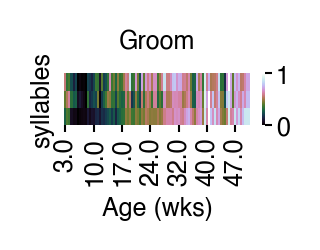

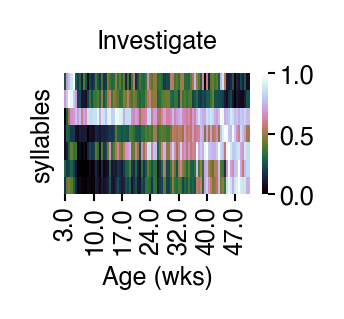

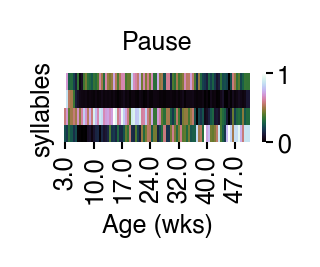

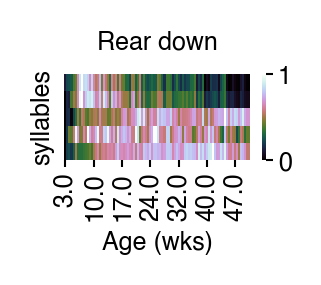

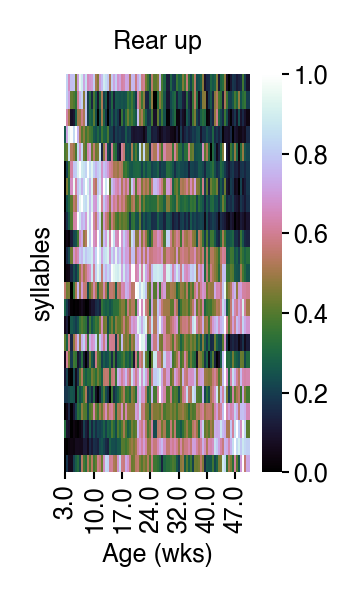

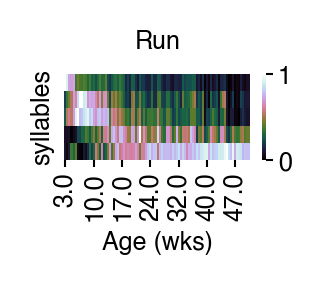

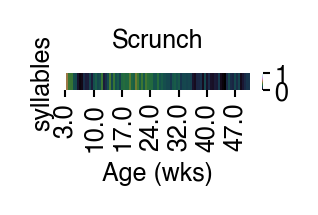

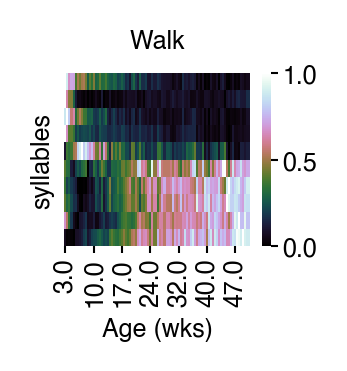

In [11]:
class_avgs = {}
class_norm_avgs = {}
for _class, _df in df.T.groupby(class_sort):
    avgs = _df.T.groupby('age').mean()
    class_avgs[_class] = avgs.mean(1)

    norm_avgs = minmax(avgs)

    peaks = (
        norm_avgs.rolling(7, min_periods=1, center=True, win_type="exponential")
        .mean(tau=3)
        .idxmax()
    )
    peaks = peaks.sort_values()
    class_norm_avgs[_class] = norm_avgs.mean(1)

    ages = avgs.index

    fig = figure(1, 0.075 * avgs.shape[1])
    #plt.imshow(norm_avgs[peaks.index].T, cmap='cubehelix', extent=(ages[0], ages[-1], avgs.shape[1], 0), aspect='auto')
    sns.heatmap(norm_avgs[peaks.index].T, cmap='cubehelix')
    plt.title(_class)
    #plt.colorbar(label="Normalized usage")
    plt.yticks([])
    #plt.xticks([10,20,30,40,50])
    plt.xlabel("Age (wks)")
    #sns.despine()
    plt.gcf().set_rasterized(False)
    fig.savefig(c.dana_save_path / "fig3"/ f'male_class-{_class}.pdf')
    

In [12]:
class_df = pd.DataFrame(class_norm_avgs)
peaks = (
    class_df.rolling(7, min_periods=1, center=True, win_type="exponential")
    .mean(tau=3)
    .idxmax()
)
peaks = peaks.sort_values()

In [13]:
col_order = ['Pause', 'Scrunch', 'Groom', 'Rear down','Rear up','Run','Investigate','Walk']
class_df_new = class_df.reindex(columns=col_order)

<Axes: xlabel='age'>

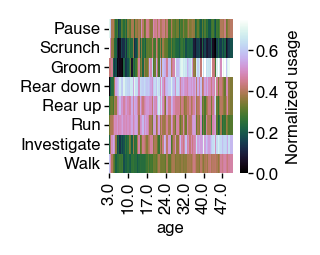

In [14]:
format_plots()
fig, ax = plt.subplots(figsize=(1, 1))
sns.heatmap(class_df_new.T, cmap='cubehelix', vmax=0.75, cbar_kws=dict(label='Normalized usage'))

In [15]:
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig3"/ 'male_syll_clusters_avg.pdf')

In [16]:
#stats

In [17]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tools.tools import pinv_extended  
from statsmodels.stats.anova import anova_lm
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from tabulate import tabulate

In [18]:
def ow_anova(data, dependent_var, factor1):
    """
    Perform two-way ANOVA.
    
    Parameters:
    data (pd.DataFrame): The input data frame.
    dependent_var (str): The name of the dependent variable column.
    factor1 (str): The name of the first factor column.
    factor2 (str): The name of the second factor column.
    
    Returns:
    pd.DataFrame: The ANOVA results.
    """
    
    # Align the data
    align_data = data.copy()
    align_data['ranked_response'] = align_data[[dependent_var]]
    # Fit an OLS model on the ranked data
    model = ols(f'ranked_response ~ {factor1}', data=align_data).fit()
    # Perform ANOVA on the fitted model
    anova_results = sm.stats.anova_lm(model, typ=3)
    
    # Convert results to a DataFrame
    anova_df = pd.DataFrame(anova_results)
    
    return anova_df

In [19]:
#males
data=class_df_new
temp = data.copy()
temp.reset_index(inplace=True)
results = []
dependent_vars = data.columns
n_tests = len(dependent_vars)  # Number of ANOVA tests

# Perform ANOVA for each dependent variable
for i, k in enumerate(dependent_vars):
    print(k)
    anova_results = ow_anova(temp, k, 'age')
    anova_results['Dependent Variable'] = k  # Add dependent variable to the results
    results.append(anova_results)
    print(tabulate(anova_results, headers='keys', tablefmt='psql'))

# Combine results into a DataFrame
results_df = pd.concat(results).reset_index()
results_df.rename(columns={'index': 'Parameter'}, inplace=True)

# Move the 'Dependent Variable' column to the first position
cols = ['Dependent Variable'] + [col for col in results_df.columns if col != 'Dependent Variable']
results_df = results_df[cols]

# Apply Bonferroni correction to the p-values
results_df['Bonferroni_corrected_p'] = results_df['PR(>F)'] * n_tests
results_df['Bonferroni_corrected_p'] = results_df['Bonferroni_corrected_p'].apply(lambda p: min(p, 1))  # p-values should not exceed 1

# Save DataFrame to CSV file
results_df.to_csv('anova_results_syllable_classes_longv2_males.csv', index=False)

print("ANOVA results with Bonferroni-corrected p-values have been saved")

Pause
+-----------+-----------+------+-----------+---------------+----------------------+
|           |    sum_sq |   df |         F |        PR(>F) | Dependent Variable   |
|-----------+-----------+------+-----------+---------------+----------------------|
| Intercept | 2.87304   |    1 | 389.143   |   1.93946e-34 | Pause                |
| age       | 0.0397803 |    1 |   5.38811 |   0.0225332   | Pause                |
| Residual  | 0.664468  |   90 | nan       | nan           | Pause                |
+-----------+-----------+------+-----------+---------------+----------------------+
Scrunch
+-----------+----------+------+----------+---------------+----------------------+
|           |   sum_sq |   df |        F |        PR(>F) | Dependent Variable   |
|-----------+----------+------+----------+---------------+----------------------|
| Intercept | 2.22195  |    1 | 167.349  |   3.03347e-22 | Scrunch              |
| age       | 0.289911 |    1 |  21.8351 |   1.03643e-05 | Scrunch    